In [ ]:
!pip install xgboost openpyxl


In [ ]:
# STEP 0: Mount Google Drive (only once per session)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# STEP 2: Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# STEP 3: Load your dataset
file_path = '/content/drive/MyDrive/dm proj/filtered_fever_data.xlsx'  # change this path to match your folder
df = pd.read_excel(file_path)

# Keep only SUPPORTS and REFUTES for binary classification
df = df[df['label'].isin(['SUPPORTS', 'REFUTES'])].copy()
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # SUPPORTS=1, REFUTES=0


In [ ]:
# STEP 4: Train/Test split (80/20 with stratify)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['claim'],
    df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)


In [ ]:
# STEP 5: Function to run TF-IDF + XGBoost + Evaluation
def run_xgboost_with_tfidf(max_features=1000, n_estimators=50, max_depth=3):
    # Vectorization
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    # XGBoost model
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    model.fit(X_train_vec, y_train)

    # Predictions
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Output
    print(f"📊 Results for TF-IDF max_features={max_features}")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Results for TF-IDF max_features=1000
Accuracy: 81.38 %
ROC AUC Score: 0.7747

Classification Report:
               precision    recall  f1-score   support

     REFUTES       0.91      0.35      0.50      5955
    SUPPORTS       0.80      0.99      0.89     16007

    accuracy                           0.81     21962
   macro avg       0.86      0.67      0.69     21962
weighted avg       0.83      0.81      0.78     21962

Confusion Matrix:
[[ 2063  3892]
 [  198 15809]]


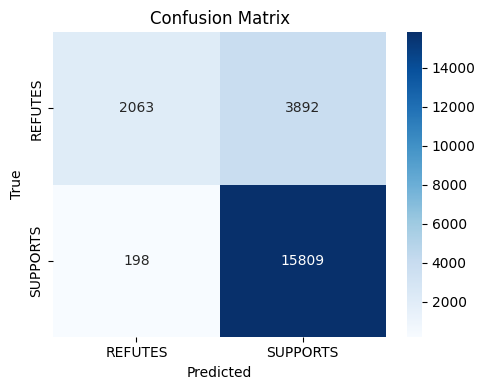

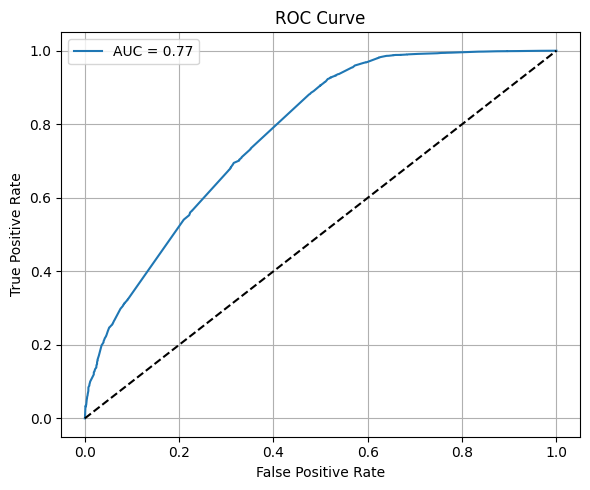

In [ ]:
# STEP 6: Run baseline model
run_xgboost_with_tfidf(max_features=1000)


In [ ]:
# Variant 1: Handling Class Imbalance using scale_pos_weight
def run_xgboost_with_class_weight(max_features=1000, n_estimators=50, max_depth=3):
    # Count class distribution
    from collections import Counter
    class_counts = Counter(y_train)
    neg, pos = class_counts[0], class_counts[1]
    weight = neg / pos

    print(f"Applying scale_pos_weight: {weight:.2f}")

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    # XGBoost with class weight
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        n_estimators=n_estimators,
        max_depth=max_depth,
        scale_pos_weight=weight
    )
    model.fit(X_train_vec, y_train)

    # Predictions
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    # Evaluation
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
    import matplotlib.pyplot as plt
    import seaborn as sns

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n📊 Variant 1 - XGBoost with Class Weight")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix (Class Weight)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Class Weight)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Applying scale_pos_weight: 0.37

📊 Variant 1 - XGBoost with Class Weight
Accuracy: 79.51 %
ROC AUC Score: 0.7723

Classification Report:
               precision    recall  f1-score   support

     REFUTES       0.67      0.47      0.56      5955
    SUPPORTS       0.82      0.91      0.87     16007

    accuracy                           0.80     21962
   macro avg       0.75      0.69      0.71     21962
weighted avg       0.78      0.80      0.78     21962

Confusion Matrix:
[[ 2822  3133]
 [ 1367 14640]]


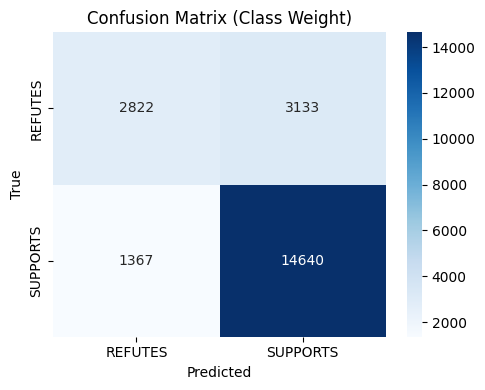

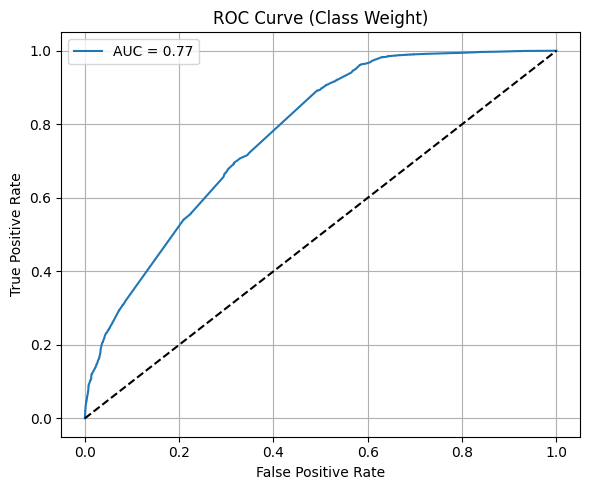

In [ ]:
run_xgboost_with_class_weight(max_features=1000)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def run_grid_search_xgboost(max_features=1000):
    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)

    # XGBoost model
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=0.37  # Keep class weight from Variant 1
    )

    # Pipeline: TF-IDF → XGBoost
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('xgb', xgb)
    ])

    # Param grid
    param_grid = {
        'xgb__n_estimators': [50, 100],
        'xgb__max_depth': [3, 5],
        'xgb__learning_rate': [0.1, 0.3]
    }

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',
        cv=3,
        verbose=1,
        n_jobs=-1  # Use all cores
    )

    # Fit
    grid.fit(X_train_text, y_train)

    print("\n✅ Best Parameters Found:")
    print(grid.best_params_)

    print("\n📊 Best Cross-Validated F1 (macro):")
    print(round(grid.best_score_, 4))

    return grid


In [ ]:
grid_result = run_grid_search_xgboost(max_features=1000)


Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Parameters Found:
{'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}

📊 Best Cross-Validated F1 (macro):
0.7213


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_best_model(grid_result):
    # Get best pipeline (TF-IDF + XGBoost)
    best_model = grid_result.best_estimator_

    # Predict on test set
    y_pred = best_model.predict(X_test_text)
    y_prob = best_model.predict_proba(X_test_text)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print results
    print("✅ Final Test Evaluation (Best GridSearch Model)")
    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix (Best Model)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Best Model)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Final Test Evaluation (Best GridSearch Model)
Accuracy: 78.99 %
ROC AUC Score: 0.8074

Classification Report:
               precision    recall  f1-score   support

     REFUTES       0.63      0.56      0.59      5955
    SUPPORTS       0.84      0.88      0.86     16007

    accuracy                           0.79     21962
   macro avg       0.73      0.72      0.72     21962
weighted avg       0.78      0.79      0.79     21962

Confusion Matrix:
[[ 3312  2643]
 [ 1972 14035]]


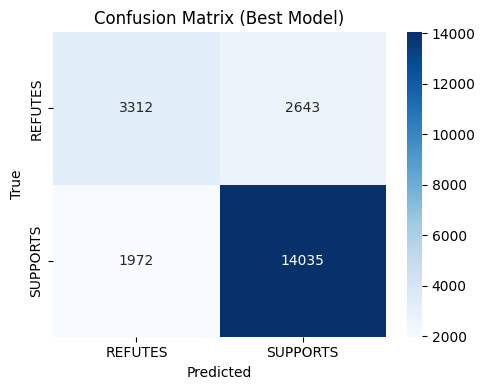

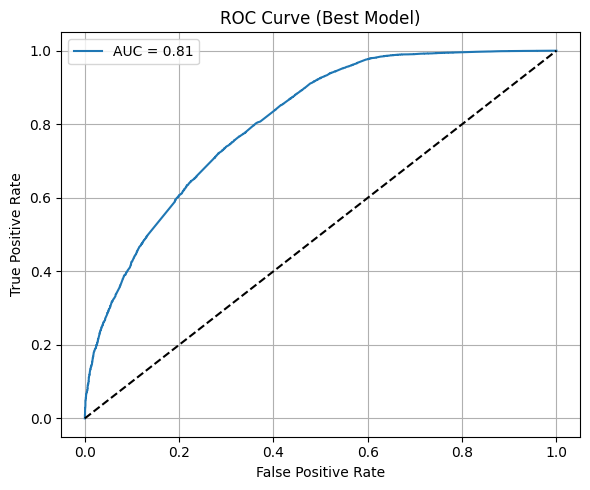

In [ ]:
evaluate_best_model(grid_result)


In [ ]:
def run_feature_size_experiments(feature_sizes=[500, 1000, 2000, 5000]):
    results = []

    for max_feat in feature_sizes:
        print(f"\n🔍 Testing TF-IDF max_features = {max_feat}")

        # Vectorization
        vectorizer = TfidfVectorizer(max_features=max_feat)
        X_train_vec = vectorizer.fit_transform(X_train_text)
        X_test_vec = vectorizer.transform(X_test_text)

        # XGBoost with best params
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0,
            learning_rate=0.3,
            max_depth=5,
            n_estimators=100,
            scale_pos_weight=0.37
        )
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        y_prob = model.predict_proba(X_test_vec)[:, 1]

        # Evaluation
        from sklearn.metrics import classification_report, roc_auc_score
        report = classification_report(
          y_test,
          y_pred,
          target_names=le.classes_,
          output_dict=True,
          zero_division=0  # prevent crashing if precision/recall are undefined
      )

        auc = roc_auc_score(y_test, y_prob)

        results.append({
            'max_features': max_feat,
            'accuracy': report['accuracy'],
            'refutes_recall': report['REFUTES']['recall'],
            'refutes_f1': report['REFUTES']['f1-score'],
            'auc': auc
        })

    return pd.DataFrame(results)


In [ ]:
variant3_results = run_feature_size_experiments()
variant3_results



🔍 Testing TF-IDF max_features = 500

🔍 Testing TF-IDF max_features = 1000

🔍 Testing TF-IDF max_features = 2000

🔍 Testing TF-IDF max_features = 5000


,max_features,accuracy,refutes_recall,refutes_f1,auc
0,500,0.780302,0.549622,0.575675,0.798356
1,1000,0.789864,0.556171,0.589376,0.807433
2,2000,0.789637,0.582032,0.600069,0.813499
3,5000,0.813587,0.544249,0.612897,0.819100


In [ ]:
def evaluate_feature_size(max_features):
    print(f"\n🔍 Evaluating model with max_features = {max_features}")

    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        learning_rate=0.3,
        max_depth=5,
        n_estimators=100,
        scale_pos_weight=0.37
    )
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
    import matplotlib.pyplot as plt
    import seaborn as sns

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("Accuracy:", round(acc * 100, 2), "%")
    print("ROC AUC Score:", round(roc_auc, 4))
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix (max_features={max_features})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (max_features={max_features})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔍 Evaluating model with max_features = 2000
Accuracy: 78.96 %
ROC AUC Score: 0.8135

Classification Report:
               precision    recall  f1-score   support

     REFUTES       0.62      0.58      0.60      5955
    SUPPORTS       0.85      0.87      0.86     16007

    accuracy                           0.79     21962
   macro avg       0.73      0.72      0.73     21962
weighted avg       0.79      0.79      0.79     21962

Confusion Matrix:
 [[ 3466  2489]
 [ 2131 13876]]


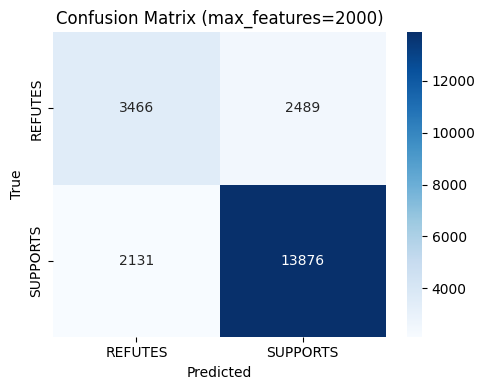

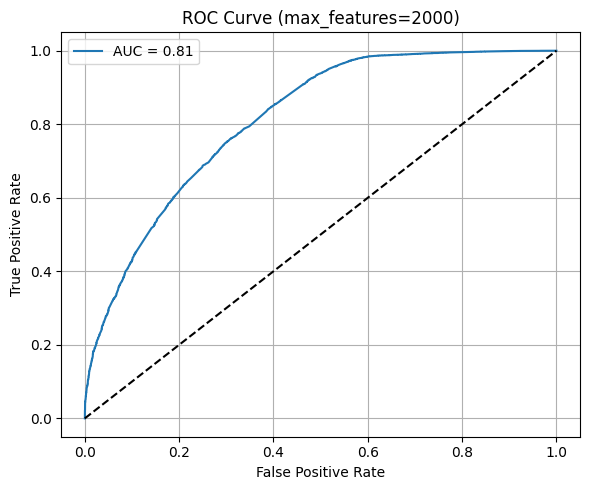


🔍 Evaluating model with max_features = 5000
Accuracy: 81.36 %
ROC AUC Score: 0.8191

Classification Report:
               precision    recall  f1-score   support

     REFUTES       0.70      0.54      0.61      5955
    SUPPORTS       0.84      0.91      0.88     16007

    accuracy                           0.81     21962
   macro avg       0.77      0.73      0.75     21962
weighted avg       0.80      0.81      0.81     21962

Confusion Matrix:
 [[ 3241  2714]
 [ 1380 14627]]


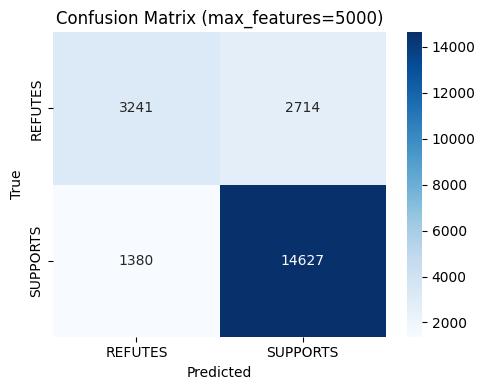

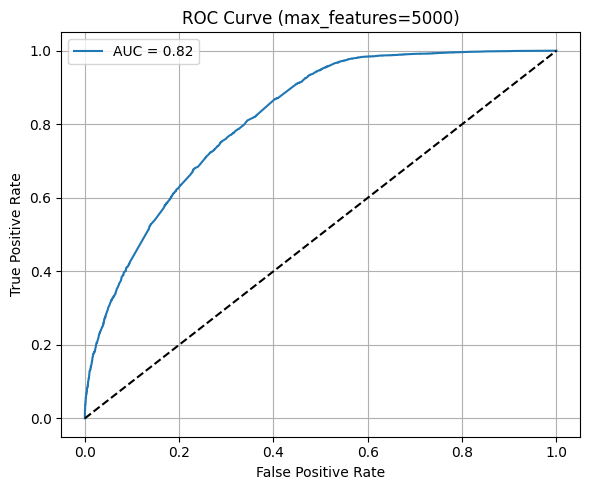

In [ ]:
evaluate_feature_size(max_features=2000)
evaluate_feature_size(max_features=5000)
